<a href="https://colab.research.google.com/github/HubertDalm/PredictingStudentsScoresML/blob/master/student_performance_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importy

In [ ]:
#!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import Dropout
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Wstępna analiza danych

In [ ]:
df = pd.read_csv("student_performance.csv")

In [ ]:
df.head()

,Socioeconomic Score,Study Hours,Sleep Hours,Attendance (%),Grades
0,0.95822,3.4,8.2,53.0,47.0
1,0.85566,3.2,5.9,55.0,35.0
2,0.68025,3.2,9.3,41.0,32.0
3,0.25936,3.2,8.2,47.0,34.0
4,0.60447,3.8,10.0,75.0,33.0


In [ ]:
print(f"Liczba wierszy: {df.shape[0]}")
print(f"Liczba kolumn: {df.shape[1]}")

Liczba wierszy: 1388
Liczba kolumn: 5


In [ ]:
df.columns

Index(['Socioeconomic Score', 'Study Hours', 'Sleep Hours', 'Attendance (%)',
       'Grades'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1388 entries, 0 to 1387
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Socioeconomic Score  1388 non-null   float64
 1   Study Hours          1388 non-null   float64
 2   Sleep Hours          1388 non-null   float64
 3   Attendance (%)       1388 non-null   float64
 4   Grades               1388 non-null   float64
dtypes: float64(5)
memory usage: 54.3 KB


In [ ]:
df.describe()

,Socioeconomic Score,Study Hours,Sleep Hours,Attendance (%),Grades
count,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000
mean,0.552274,4.560807,8.047262,58.536023,40.691643
std,0.261272,1.897581,1.370700,11.675287,9.467358
min,0.101280,0.800000,4.800000,40.000000,32.000000
25%,0.322118,3.475000,7.000000,49.000000,34.000000
50%,0.545945,3.900000,8.400000,57.000000,35.000000
75%,0.789610,5.900000,9.100000,66.000000,47.000000
max,0.999820,10.000000,10.000000,100.000000,91.000000


In [ ]:
missing_values = df.isna().sum()
print('liczba wartości pustych:', '\n', missing_values)

liczba wartości pustych: 
 Socioeconomic Score    0
Study Hours            0
Sleep Hours            0
Attendance (%)         0
Grades                 0
dtype: int64


In [ ]:
duplicates = df.duplicated().sum()
print('liczba duplikatów: ', duplicates)

liczba duplikatów:  0


In [ ]:
# usuwanie wartości odstających
def outlier_check(row, colname):
    Q1 = row[colname].quantile(0.25)
    Q3 = row[colname].quantile(0.75)
    IQR = Q3 - Q1
    lower_b = Q1 - 1.5 * IQR
    upper_b = Q3 + 1.5 * IQR
    outlier = row.loc[(row[colname] < lower_b) | (row[colname] > upper_b)]
    return outlier

outliers = pd.DataFrame()

for col in df.select_dtypes(include=['number']).columns:
    outliers_in_col = outlier_check(df, col)
    outliers = pd.concat([outliers, outliers_in_col])

outliers.reset_index(drop=True, inplace=True)

In [ ]:
print('Liczba wartości odstających', len(outliers))

Liczba wartości odstających 50


In [ ]:
df = df[~df.index.isin(outliers.index)]
df.shape

(1338, 5)

In [ ]:
df.corr()['Grades'].sort_values(ascending=False)

,Grades
Grades,1.000000
Study Hours,0.810220
Socioeconomic Score,0.336193
Attendance (%),0.329562
Sleep Hours,-0.127672


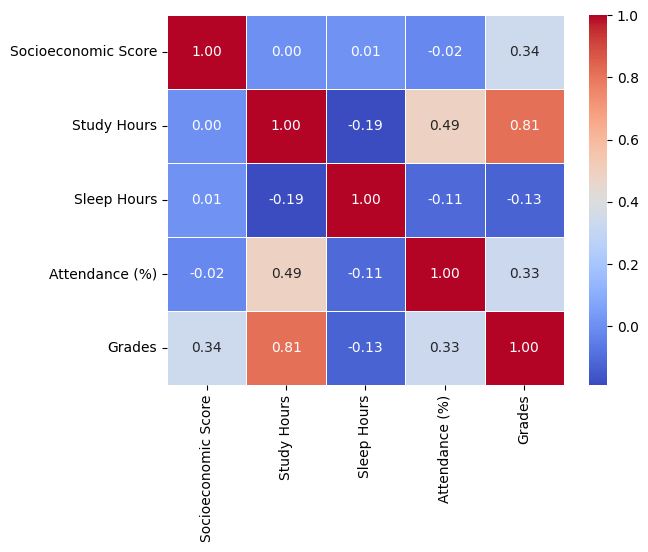

In [ ]:
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidth=.5)
plt.show()

# Funkcje do wizualizacji / oceny modeli

In [ ]:
# Tablica do przechowywania rezultatów modeli
model_results = []
table_of_results = {}
# funkcja do tworzenia tabeli przedstawiającej wartości rzeczywiste vs przewidywane
def real_vs_predicted_values(y_test, y_pred):
  y_test = y_test.flatten() if len(y_test.shape) > 1 else y_test
  y_pred = y_pred.flatten() if len(y_pred.shape) > 1 else y_pred

  results = pd.DataFrame({
      'Rzeczywiste wartości': y_test,
      'Przewidywane wartości': y_pred
  })
  print(results.head(6))
  return results

# funkcja do tworzenia wykresu wartości przewidywanych vs rzeczywistych
def real_vs_predicted_plot(model, y_test, y_pred):
    y_test = y_test.flatten() if len(y_test.shape) > 1 else y_test
    y_pred = y_pred.flatten() if len(y_pred.shape) > 1 else y_pred

    sns.set_style("whitegrid")

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.7, label='Przewidywania')
    plt.plot(
        [min(y_test), max(y_test)], [min(y_test), max(y_test)],
        color='red', linestyle='--', linewidth=2, label='Idealna linia (y=x)'
    )

    plt.xlabel('Rzeczywiste wartości', fontsize=12)
    plt.ylabel('Przewidywane wartości', fontsize=12)
    plt.title(f'Rzeczywiste vs przewidywane ({model})', fontsize=14, fontweight='bold')

    plt.grid(visible=True, which='major', linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)

    min_val = min(min(y_test), min(y_pred))
    max_val = max(max(y_test), max(y_pred))
    plt.xlim(min_val - 0.1 * abs(min_val), max_val + 0.1 * abs(max_val))
    plt.ylim(min_val - 0.1 * abs(min_val), max_val + 0.1 * abs(max_val))

    plt.tight_layout()
    plt.show()

# funkcja do pobierania metryk
def metrics(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  return mse, r2

# funkcja która dodaje model do porównania
def add_to_comparision(model_name, mse, r2,results):
  model_results.append({
      'Model': model_name,
      'Mean Squared Error': mse,
      'R-squared Score': r2
  })
  # funcka do tworzenia tabeli z przewidywanymi wartosciami
def add_to_results_table(model_name, results):
  table_of_results[model_name] = results

# Modele ML

In [ ]:
X = df.drop('Grades', axis=1)
y = df['Grades']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model: LinearRegression
MSE: 25.382, R2: 0.754
      Rzeczywiste wartości  Przewidywane wartości
814                   34.0              24.685349
937                   53.0              48.203867
940                   34.0              34.616334
1343                  54.0              43.139730
309                   39.0              45.666585
1362                  35.0              23.119805


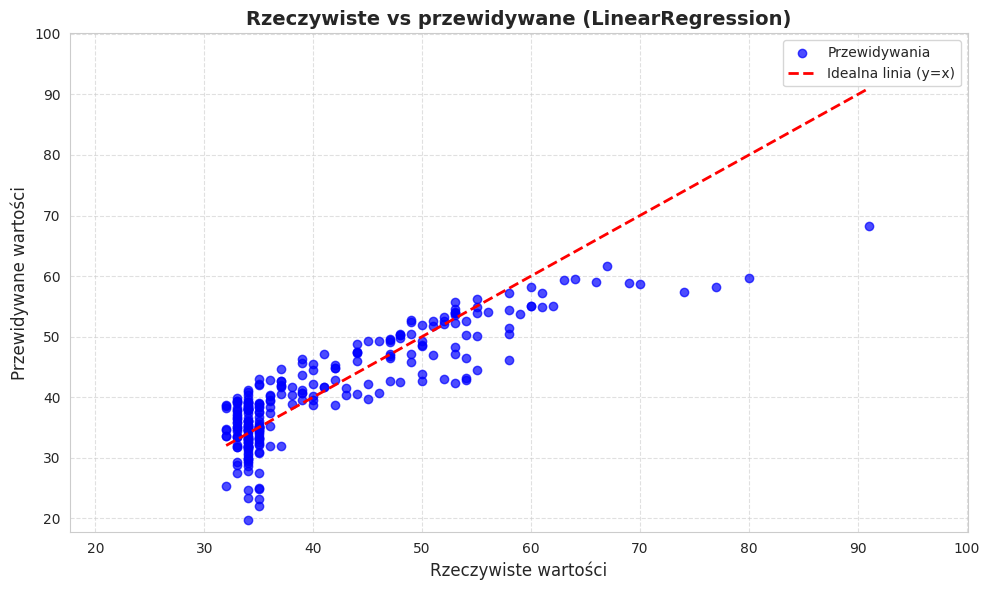

Model: Ridge
Best Params: {'model__alpha': 1.0}
MSE: 25.387, R2: 0.754
      Rzeczywiste wartości  Przewidywane wartości
814                   34.0              24.699144
937                   53.0              48.193830
940                   34.0              34.626283
1343                  54.0              43.132413
309                   39.0              45.670326
1362                  35.0              23.141534


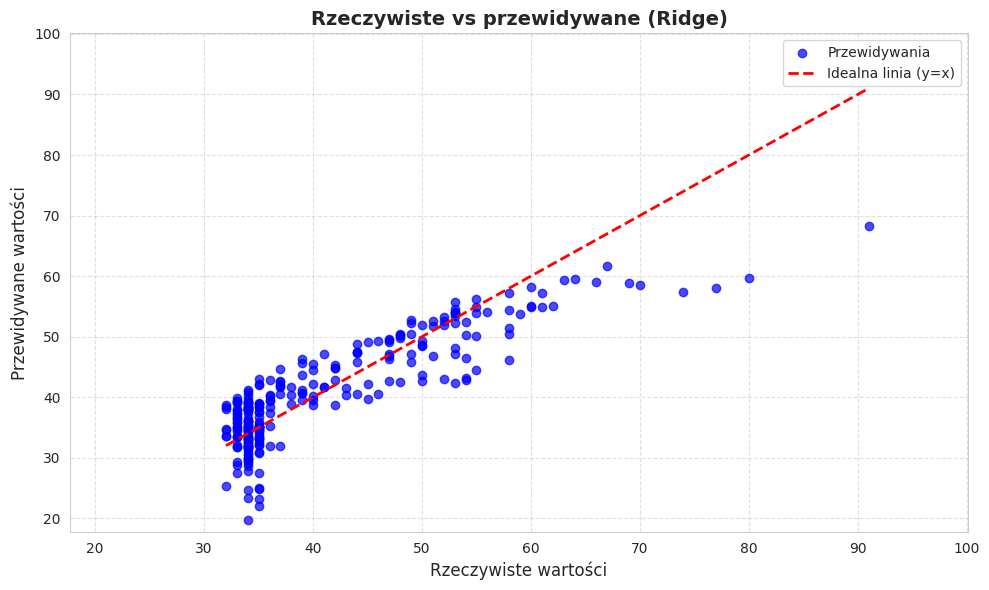

Model: DecisionTreeRegressor
Best Params: {'model__min_samples_split': 5, 'model__min_samples_leaf': 5, 'model__max_depth': 7}
MSE: 4.761, R2: 0.954
      Rzeczywiste wartości  Przewidywane wartości
814                   34.0              33.960352
937                   53.0              51.307692
940                   34.0              33.960352
1343                  54.0              53.200000
309                   39.0              39.437500
1362                  35.0              33.960352


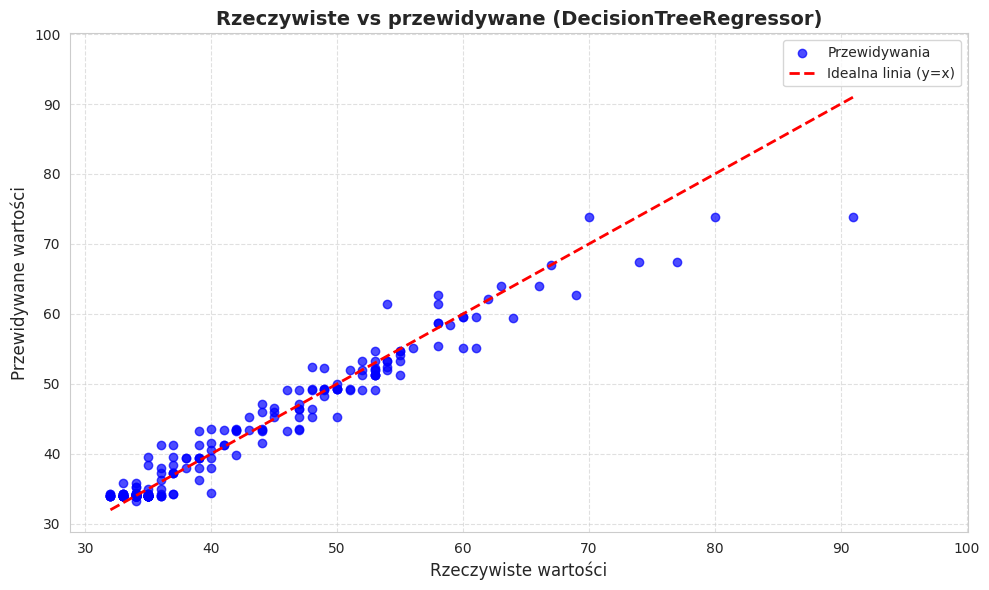

Model: SVR
Best Params: {'model__kernel': 'rbf', 'model__epsilon': 0.5, 'model__C': 100}
MSE: 2.628, R2: 0.975
      Rzeczywiste wartości  Przewidywane wartości
814                   34.0              34.401392
937                   53.0              50.860860
940                   34.0              33.972112
1343                  54.0              52.828539
309                   39.0              36.579752
1362                  35.0              33.521963


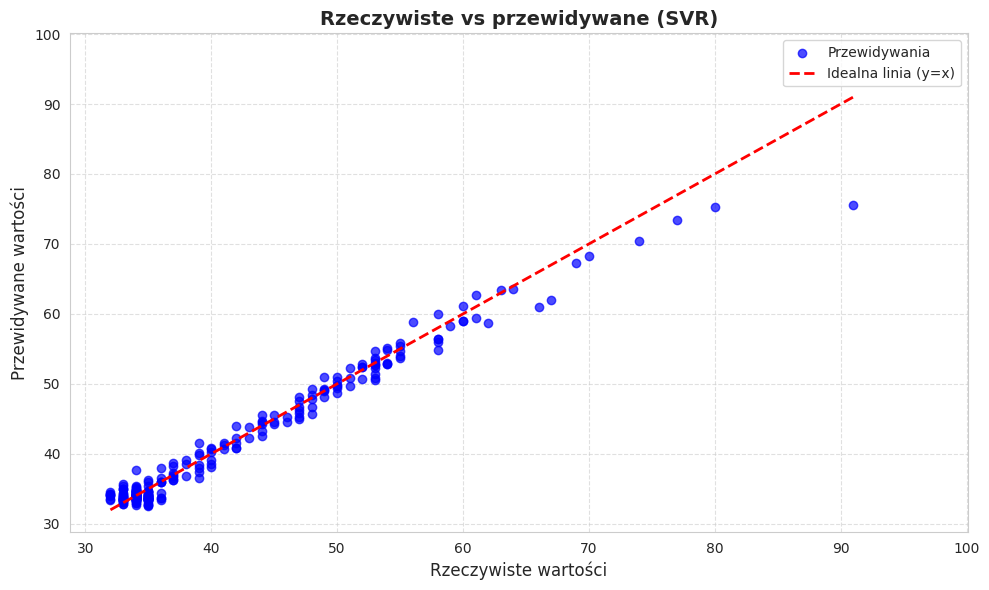

Model: KNeighborsRegressor
Best Params: {'model__weights': 'distance', 'model__n_neighbors': 7}
MSE: 10.849, R2: 0.895
      Rzeczywiste wartości  Przewidywane wartości
814                   34.0              34.100471
937                   53.0              50.036253
940                   34.0              33.869847
1343                  54.0              49.293508
309                   39.0              40.970570
1362                  35.0              34.094827


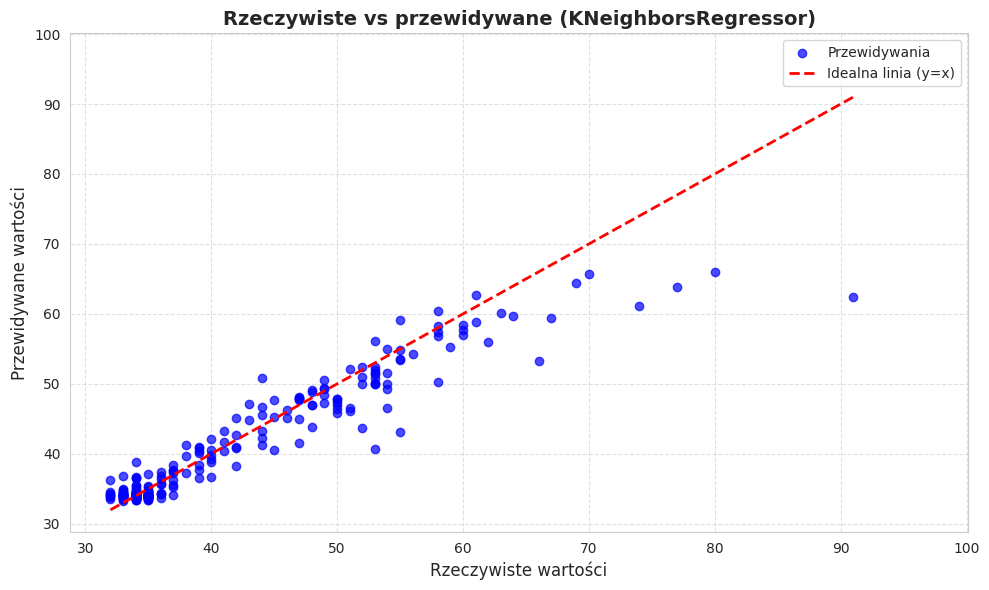

Model: GradientBoostingRegressor
Best Params: {'model__n_estimators': 100, 'model__max_depth': 5, 'model__learning_rate': 0.1}
MSE: 2.465, R2: 0.976
      Rzeczywiste wartości  Przewidywane wartości
814                   34.0              33.901080
937                   53.0              50.983271
940                   34.0              34.109406
1343                  54.0              52.937608
309                   39.0              40.057186
1362                  35.0              34.087608


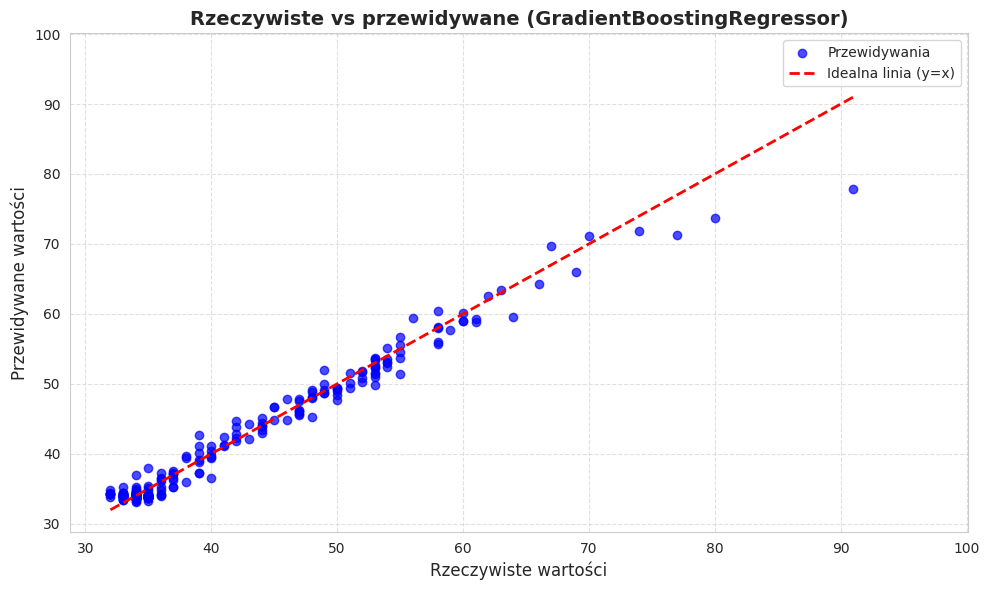

In [ ]:
y_test_df = pd.DataFrame(y_test)
# Parametry dla różnych modeli
ridge_params = {'model__alpha': [0.1, 1.0, 10.0, 100.0, 500.0, 1000.0]}
dt_params = {
    'model__max_depth': [3, 5, 7, 10, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 5],

}

svr_params = {
    'model__C': [0.1, 1, 10, 100],
    'model__epsilon': [0.1, 0.2, 0.5],
    'model__kernel': ['linear', 'poly', 'rbf']
}
knn_params = {
    'model__n_neighbors': [3, 5, 7, 10],
    'model__weights': ['uniform', 'distance']
}
gbr_params = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7]
}

# Modele
models = [
    (LinearRegression(), X_train, X_test, y_train, y_test, {'use_scaling': True, 'search_method': None}),  # Regresja liniowa
    (Ridge(), X_train, X_test, y_train, y_test, {'use_scaling': True, 'search_method': "randomized", 'params': ridge_params}),  # Ridge regression
    (DecisionTreeRegressor(random_state=42), X_train, X_test, y_train, y_test, {'use_scaling': False, 'search_method': "randomized", 'params': dt_params}),  # Drzewo decyzyjne
    (SVR(), X_train, X_test, y_train, y_test, {'use_scaling': True, 'search_method': "randomized", 'params': svr_params}),  # Support Vector Regression
    (KNeighborsRegressor(), X_train, X_test, y_train, y_test, {'use_scaling': True, 'search_method': "randomized", 'params': knn_params}),  # K-Nearest Neighbors
    (GradientBoostingRegressor(random_state=42), X_train, X_test, y_train, y_test, {'use_scaling': False, 'search_method': "randomized", 'params': gbr_params}),  # Gradient Boosting Regressor
]


# Funkcja do trenowania i oceny modelu
def train_and_evaluate(model, X_train, X_test, y_train, y_test, params=None, use_scaling=False, search_method=None):
    # Przygotowanie pipeline'u (skalowanie, jeśli potrzeba)
    steps = []
    if use_scaling:
        steps.append(('scaler', StandardScaler()))
    steps.append(('model', model))

    pipeline = Pipeline(steps)

    # Jeśli jest potrzeba strojenia hiperparametrów
    if search_method == "randomized":
        # Jeśli model wymaga przeszukiwania
        search = RandomizedSearchCV(pipeline, param_distributions=params, cv=5, n_iter=5, random_state=42)
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        best_params = search.best_params_
    else:
        pipeline.fit(X_train, y_train)
        best_model = pipeline
        best_params = None

    # Predykcje
    y_pred = best_model.predict(X_test)
    y_pred = np.clip(y_pred, None, 100)

    # Obliczanie wyników
    mse, r2 = metrics(y_test, y_pred)

    # Wypisanie wyników
    print(f"Model: {model.__class__.__name__}")
    if best_params:
        print(f"Best Params: {best_params}")
    print(f"MSE: {mse:.3f}, R2: {r2:.3f}")
    results = real_vs_predicted_values(y_test, y_pred)
    merged = pd.merge(y_test, results, left_index=True, right_index=True)
    real_vs_predicted_plot(model.__class__.__name__, y_test, y_pred)


    # Dodanie do tabeli z wartosciami przewidywaniymi przez model
    add_to_results_table(model.__class__.__name__, results)

    # Dodanie modelu do porównania
    add_to_comparision(model.__class__.__name__, mse, r2,results)

    return merged

# Iteracja przez modele
for model, X_train, X_test, y_train, y_test, config in models:
    train_and_evaluate(
        model,
        X_train,
        X_test,
        y_train,
        y_test,
        params=config.get('params', None),
        use_scaling=config['use_scaling'],
        search_method=config['search_method']
    )


# Sieć neuronowa

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.5250 - val_loss: 0.4541
Epoch 2/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4390 - val_loss: 0.3983
Epoch 3/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3852 - val_loss: 0.3474
Epoch 4/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3358 - val_loss: 0.3028
Epoch 5/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2917 - val_loss: 0.2625
Epoch 6/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2532 - val_loss: 0.2273
Epoch 7/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2186 - val_loss: 0.1963
Epoch 8/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1893 - val_loss: 0.1692
Epoch 9/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1630 - val_loss: 0.1456
Epoch 10/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1400 - val_loss: 0.1251
Epoch 11/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1202 - val_loss: 0.1074
Epoch 12/2000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

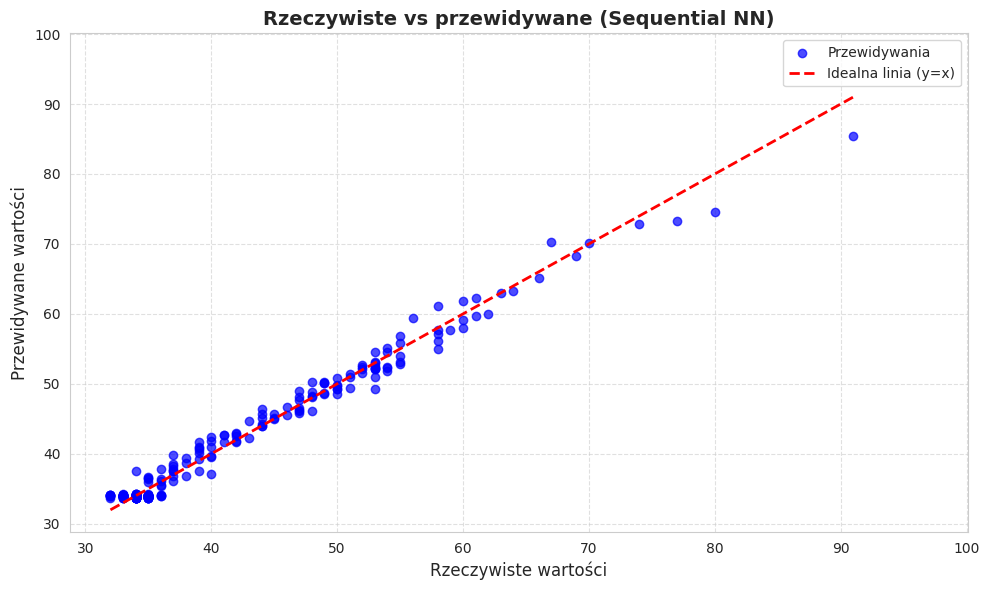

In [ ]:
# Skalowanie danych wejściowych
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Skalowanie danych wyjściowych
scaler_y = MinMaxScaler()
y_train = np.array(y_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

# Tworzenie modelu
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1)  # Aktywacja liniowa dla regresji
])

# Kompilacja modelu
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Trenowanie modelu
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=2000,
    batch_size=64,
    verbose=1,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Predykcje
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_pred = np.clip(y_pred, None, 100)

# Wyniki
mse, r2 = metrics(y_test, y_pred)
print(f"MSE: {mse:.3f}, R2: {r2:.3f}")
results=real_vs_predicted_values(y_test, y_pred)
real_vs_predicted_plot(model.__class__.__name__ + ' NN', y_test, y_pred)

# Dodanie do tabeli z wartosciami przewidywaniymi przez model
add_to_results_table(model.__class__.__name__, results)

# Dodanie modelu do porównania
add_to_comparision("Neural Network", mse, r2,results)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Najlepsze parametry: {'n_estimators': 1500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 30, 'bootstrap': True}
MSE: 3.396, R2: 0.967
      Rzeczywiste wartości  Przewidywane wartości
814                   34.0              33.551119
937                   53.0              51.242188
940                   34.0              34.273388
1343                  54.0              51.985453
309                   39.0              40.327190
1362                  35.0              34.036573


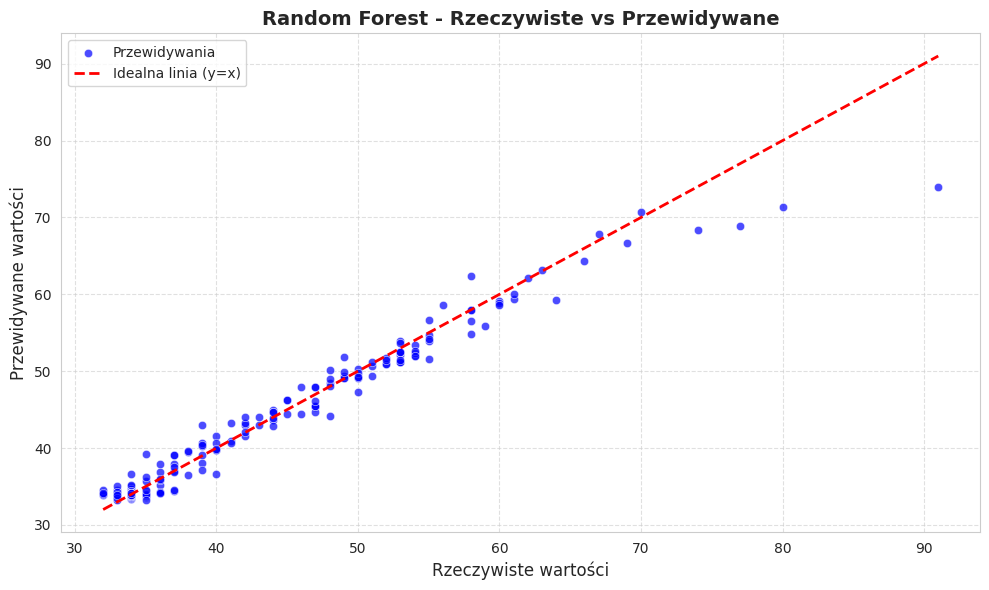

In [ ]:
# Parametry do optymalizacji
rf_params = {
    'n_estimators': [100, 200, 500, 1000, 1500],
    'max_depth': [10, 20, 30, 50, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Random Forest z RandomizedSearchCV
rf = RandomForestRegressor(random_state=42)
search = RandomizedSearchCV(
    rf, param_distributions=rf_params,
    n_iter=100, cv=10, scoring='r2',
    random_state=42, verbose=2, n_jobs=-1
)
search.fit(X_train, y_train)

# Najlepszy model
best_rf = search.best_estimator_
print(f"Najlepsze parametry: {search.best_params_}")

# Predykcja i wyniki
y_pred = best_rf.predict(X_test)
y_pred = np.clip(y_pred, None, 100)  # Zapewnienie, że predykcja mieści się w zakresie

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.3f}, R2: {r2:.3f}")
results = real_vs_predicted_values(y_test, y_pred)

# Dodanie do tabeli z wartosciami przewidywaniymi przez model
add_to_results_table("Random Forest", results)




# Wykres rzeczywiste vs przewidywane
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue', alpha=0.7, label='Przewidywania')
plt.plot(
    [min(y_test), max(y_test)], [min(y_test), max(y_test)],
    color='red', linestyle='--', linewidth=2, label='Idealna linia (y=x)'
)
plt.xlabel('Rzeczywiste wartości', fontsize=12)
plt.ylabel('Przewidywane wartości', fontsize=12)
plt.title('Random Forest - Rzeczywiste vs Przewidywane', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(visible=True, which='major', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Dodanie modelu do podsumowania
model_results.append({
    'Model': 'Random Forest',
    'Mean Squared Error': mse,
    'R-squared Score': r2
})

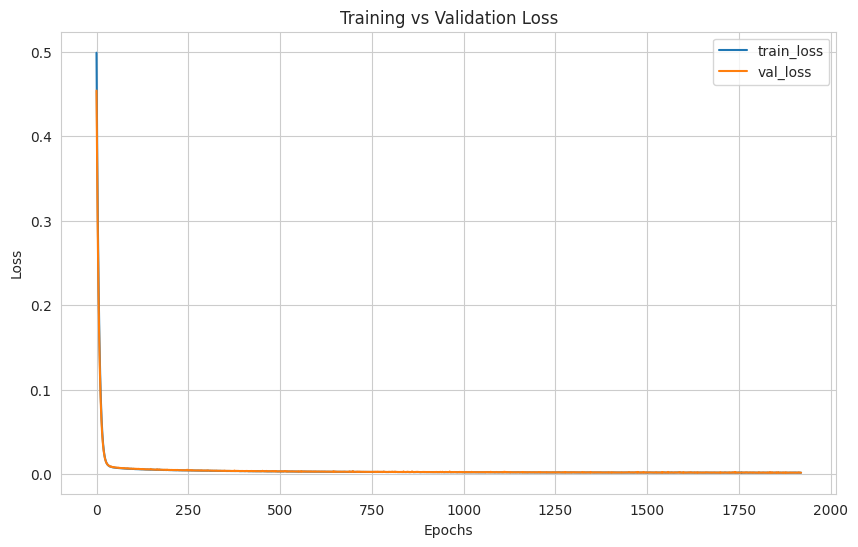

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Podsumowanie

In [ ]:
model_results_df = pd.DataFrame(model_results)
model_results_df.sort_values(by='R-squared Score', ascending=True, inplace=True)
model_results_df

,Model,Mean Squared Error,R-squared Score
1,Ridge,25.386695,0.754115
0,LinearRegression,25.382241,0.754158
4,KNeighborsRegressor,10.848973,0.894921
2,DecisionTreeRegressor,4.761080,0.953886
7,Random Forest,3.395826,0.967109
3,SVR,2.627798,0.974548
5,GradientBoostingRegressor,2.465384,0.976121
6,Neural Network,1.641006,0.984106


<ipython-input-22-9273b75e3007>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(model_results_df['Model'], fontsize=12)


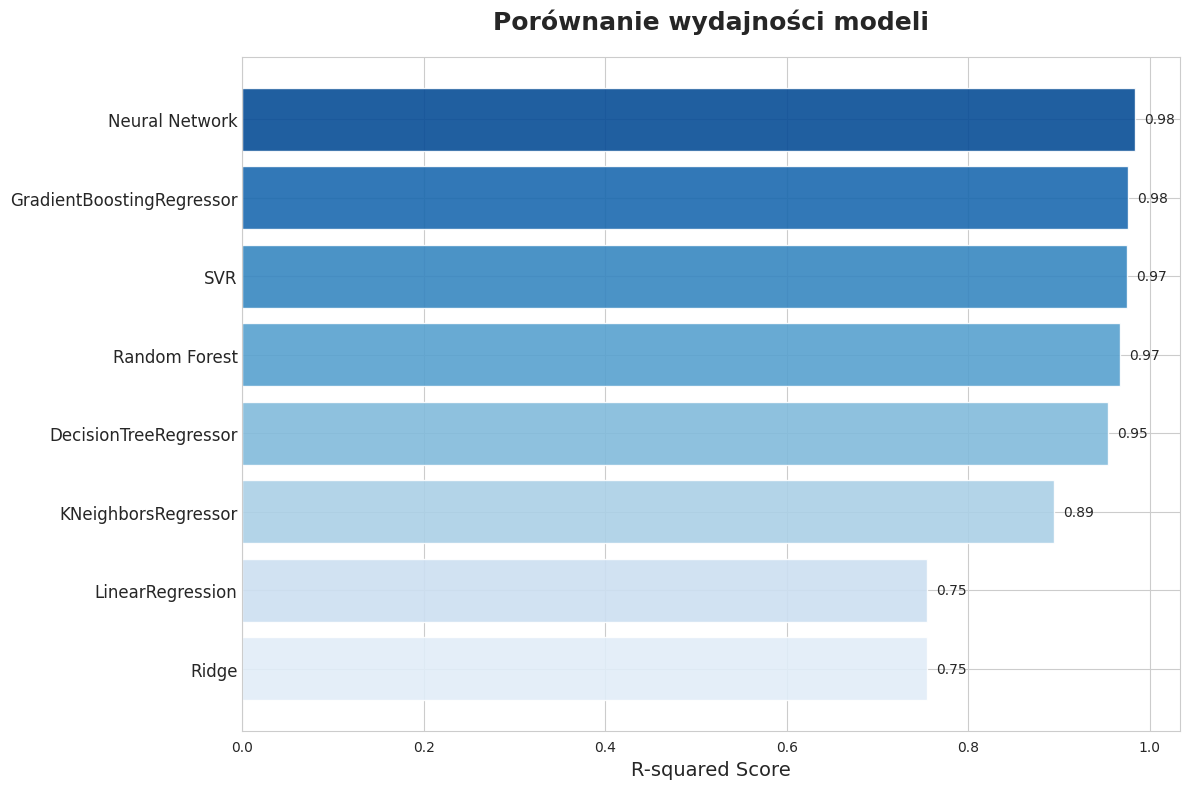

In [ ]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))

colors = sns.color_palette("Blues", len(model_results_df))

bars = ax.barh(
    model_results_df['Model'],
    model_results_df['R-squared Score'],
    color=colors,
    alpha=0.9
)

for bar, score in zip(bars, model_results_df['R-squared Score']):
    ax.text(
        bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
        f"{score:.2f}",
        va='center', fontsize=10
    )

ax.set_xlabel("R-squared Score", fontsize=14)
ax.set_title("Porównanie wydajności modeli", fontsize=18, fontweight='bold', pad=20)

ax.set_yticklabels(model_results_df['Model'], fontsize=12)
ax.tick_params(axis='y', which='both', length=0)

plt.tight_layout()
plt.show()

In [ ]:
model_table=[]
for name,df in table_of_results.items():
  model_table.append(df["Przewidywane wartości"].rename(name))

df_model_table = pd.concat(model_table, axis=1)
df_model_table['Rzeczywiste wartosci'] = table_of_results['LinearRegression']['Rzeczywiste wartości']
df_model_table.head(10)

,LinearRegression,Ridge,DecisionTreeRegressor,SVR,KNeighborsRegressor,GradientBoostingRegressor,Sequential,Random Forest,Rzeczywiste wartosci
814,24.685349,24.699144,33.960352,34.401392,34.100471,33.901080,33.703602,33.551119,34.0
937,48.203867,48.193830,51.307692,50.860860,50.036253,50.983271,51.043373,51.242188,53.0
940,34.616334,34.626283,33.960352,33.972112,33.869847,34.109406,33.988041,34.273388,34.0
1343,43.139730,43.132413,53.200000,52.828539,49.293508,52.937608,52.335651,51.985453,54.0
309,45.666585,45.670326,39.437500,36.579752,40.970570,40.057186,40.877171,40.327190,39.0
1362,23.119805,23.141534,33.960352,33.521963,34.094827,34.087608,33.653751,34.036573,35.0
949,29.271463,29.282415,33.960352,33.477133,33.554299,33.962841,33.730492,33.700033,33.0
802,38.400206,38.403252,34.400000,34.725462,36.529743,35.224292,34.237247,35.083185,34.0
1336,57.348947,57.323712,67.428571,70.439414,61.150247,71.801513,72.844025,68.377367,74.0
757,39.577936,39.586876,35.000000,35.944043,36.388436,35.244278,35.586594,35.160252,36.0


In [ ]:
# for name,df in table_of_results.items():
#   print(name, ':\n')
#   display(df[['Rzeczywiste wartości','Przewidywane wartości']].head(10))